In [1]:
import xml.dom.minidom as xmldom
import pandas as pd
import geopandas as gpd
import osmnx as ox

In [2]:
from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon
from shapely.geometry import Point
from shapely import affinity
from geopandas import GeoSeries
from geopandas import GeoDataFrame
import math

### 目的：用量化的方法来描述每一类问题，转化为等维的特征矩阵，以便进行聚类分析
## 1.地块√
* 以每个多边形中心点为坐标原点，将多边形轮廓等长度细分，得到若干（例如100个）细分后的坐标点。归一化后可得到等维度的特征矩阵
![](1.png)
## 2.肌理
* 以图底关系转换后的“图斑”进行研究可能是一个方法，但目前查到的资料里，基本都是定性地进行分析，难以描述具体几何形态
* "测度的角度引入的维数概念，为了定量地描述客观事物的“非规则”程度"
![](微信截图_20200511153632.png)
## 3.路网
* 资料查找中，问题与肌理类似
## 4.业态√
* 提取一定半径内几类商业POI的数量，工作方法和最初提取校园POI的流程一致
![](微信截图_20200428083544.png)

In [3]:
def parseUsefulData (INPUT_OSM):
    '''
    对第一步提取后的osm校园文件进行数据清洗
    '''
    print('...')
    dom = xmldom.parse(INPUT_OSM)
    element = dom.documentElement
    sub_element_n = element.getElementsByTagName("node")
    sub_element_w_raw = element.getElementsByTagName("way")
    
    for i in range(len(sub_element_w_raw)):
        way_tags = sub_element_w_raw[i].getElementsByTagName("tag")
        string = ''
        name = ''
        for j in range(len(way_tags)):   
            string = string + way_tags[j].getAttribute('k')+way_tags[j].getAttribute('v')
            if way_tags[j].getAttribute('k') == 'name':
                name = way_tags[j].getAttribute('v')
        if 'university' not in string or 'building' in string:
            element.removeChild(sub_element_w_raw[i])
    sub_element_w = element.getElementsByTagName("way")
    print('data parsing done!')
    return sub_element_n,sub_element_w

In [74]:
sub_element_n,sub_element_w = parseUsefulData('E:/AAA_Study/202003_GraduationProject/MapData/OSMData/sources/extracted/test.osm')

...
data parsing done!


In [30]:
def getSitePOIData (sub_element_n,sub_element_w):
    '''
    提取全部site的POI信息：'OSMID','name','center_lat','center_lon','north'、'south'、'east'、'west'
    '''
#     sub_element_n,sub_element_w = parseUsefulData(INPUT_OSM)
    site_poi_data_stack = []
    
    for i in range(len(sub_element_w)):
        OSMID = sub_element_w[i].getAttribute('id')
        temp_lat = []
        temp_lon = []
        name = ''
        way_tags = sub_element_w[i].getElementsByTagName("tag")
        for j in range(len(way_tags)):    
            if way_tags[j].getAttribute('k') == 'name':
                name = way_tags[j].getAttribute('v')
                
        way_nds = sub_element_w[i].getElementsByTagName("nd")
        for k in range(len(way_nds)-1):
            node_id = way_nds[k].getAttribute('ref')
            for m in range(len(sub_element_n)):
                if sub_element_n[m].getAttribute('id') == node_id:
                    temp_lat.append(float(sub_element_n[m].getAttribute('lat')))
                    temp_lon.append(float(sub_element_n[m].getAttribute('lon')))
        center_lat = sum(temp_lat)/len(temp_lat)
        center_lon = sum(temp_lon)/len(temp_lon)
        print(temp_lat)
        site_poi_data_stack.append([OSMID,name,center_lat,center_lon,max(temp_lat),min(temp_lat),max(temp_lon),min(temp_lon)])
        
    sitePOIData = pd.DataFrame(site_poi_data_stack,columns=['OSMID','name','center_lat','center_lon','north','south','east','west'])
    return sitePOIData

In [31]:
test = getSitePOIData(sub_element_n,sub_element_w)
test.head()

[51.7571934, 51.7571604, 51.7573166, 51.7574167, 51.7574329, 51.7574883, 51.7572723, 51.7570986, 51.7570964, 51.7570736, 51.7570703, 51.7571177, 51.7570783]


,OSMID,name,center_lat,center_lon,north,south,east,west
0,113969754,,51.757217,-1.260516,51.757488,51.75707,-1.260221,-1.260944


In [5]:
def getShapeProject(sub_element_n,sub_element_w):
    '''
    坐标系转换，将全部场地地块提取为实际大小的多边形，返回GeoDataFrame：'OSMID','geometry_type','geometry'
    '''
    print('......')
    geofence =[]
    for i in range(len(sub_element_w)):
        OSMID = sub_element_w[i].getAttribute('id')
        coords = []
        way_nds = sub_element_w[i].getElementsByTagName("nd")
        for j in range(len(way_nds)):
            node_id = way_nds[j].getAttribute('ref')
            for k in range(len(sub_element_n)):
                if sub_element_n[k].getAttribute('id') == node_id:
                    coords.append((float(sub_element_n[k].getAttribute('lon')),float(sub_element_n[k].getAttribute('lat'))))
        geofence.append({'OSMID': OSMID,'geometry_type':'POLYGON','geometry': coords})
    geofenceDf = pd.DataFrame(geofence)
    print('all sites coordinates saved')
    
    geometryList=[]
    for i in range(0, len(geofenceDf)):
        if geofenceDf.iloc[i]['geometry_type']=='POLYGON':
            geofencePolygon = Polygon(geofenceDf.iloc[i]['geometry'])
#             geofencePolygon = affinity.translate(geofencePolygon,xoff=geofencePolygon.centroid.x*(-1), yoff=geofencePolygon.centroid.y*(-1))
            geometryList.append(geofencePolygon)

    gdf = GeoDataFrame(geofenceDf, geometry=geometryList)
    gdf.crs =  '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'

    # calculate the centroid of the union of all the geometries in the
    # GeoDataFrame
    avg_longitude = gdf['geometry'].unary_union.centroid.x

    # calculate the UTM zone from this avg longitude and define the UTM
    # CRS to project
    utm_zone = int(math.floor((avg_longitude + 180) / 6.) + 1)
    utm_crs = '+proj=utm +zone={} +ellps=WGS84 +datum=WGS84 +units=m +no_defs'.format(utm_zone)
    # project the GeoDataFrame to the UTM CRS
    projected_gdf = gdf.to_crs(utm_crs)
    
    
    print(projected_gdf.length)
    print(projected_gdf.area)
    print('all sites gdf projected!')
    return projected_gdf

In [75]:
projected_gdf = getShapeProject(sub_element_n,sub_element_w)
print('*******GDF SHAPE:',projected_gdf.shape)
projected_gdf

......
all sites coordinates saved
0    165.700196
1    356.633144
dtype: float64
0    1405.039472
1    7635.796366
dtype: float64
all sites gdf projected!
*******GDF SHAPE: (2, 3)


,OSMID,geometry_type,geometry
0,113969754,POLYGON,"POLYGON ((620042.971 5735464.331, 620035.577 5..."
1,46120938,POLYGON,"POLYGON ((689379.316 5726875.132, 689367.163 5..."


#### 在轮廓图上显示路网

In [7]:
from descartes import PolygonPatch

In [32]:
# get the street network, with retain_all=True to retain all the disconnected islands' networks
G = ox.graph_from_point((40.344653,-76.933055),distance=400)
G = ox.project_graph(G)

fpG = ox.footprints.footprints_from_point((40.344653,-76.933055),distance=200)
fpG_proj = ox.project_gdf(fpG)

In [10]:
from matplotlib import pyplot as plt

In [127]:
# to this matplotlib axis, add the place shape as descartes polygon patches
i = 0
for i in range (len(projected_gdf)):
#     geometry = projected_gdf.iloc[i]['geometry']   
    fig_width=(99.54065469/92.95895867)*8
    fig, ax = ox.plot_graph(G, fig_height=8,fig_width = fig_width, show=False, close=False,bgcolor='#363737',edge_linewidth=2.5, edge_color='white',node_alpha = 0.0)
    fig, ax = ox.footprints.plot_footprints(fpG_proj, fig=fig, ax=ax, set_bounds=False,color='silver',
                                save=False, show=False, close=False)
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 5, wspace = 5)
    plt.margins(0,0)
    plt.close()
#     patch = PolygonPatch(geometry, fc='grey', ec='grey', linewidth=3, alpha=0.8, zorder=-1)
#     ax.add_patch(patch)

#     margin = 0.0
#     west, south, east, north = geometry.bounds
#     margin_ns = (north - south) * margin
#     margin_ew = (east - west) * margin
#     ax.set_ylim((south - margin_ns, north + margin_ns))
#     ax.set_xlim((west - margin_ew, east + margin_ew))
    name = 'E:/AAA_Study/202003_GraduationProject/zbzCode/images/'+ str(i)+'.jpg'
    i =i+1
    fig.savefig(name, facecolor='#363737')


In [70]:
def splitPolygon(segment_num,projected_gdf):
    '''
    将多边形（多段线）等分为若干段，并将坐标原点移动至地块中心，返回每个点坐标和连线长度（从第一象限最左点计起）
    '''
    result_length = []
    result_coords = []
    origin = Point(0,0)
    
    for i in range (len(projected_gdf)):
        each_result_length = []
        each_result_coord = []
        each_result_x = []
        each_result_y = []
        
        #从gdf中提取全部polygon，平移至中心点，计算步长，获取顶点
        polygon = projected_gdf.iloc[i]['geometry']
        polygon = affinity.translate(polygon,xoff=polygon.centroid.x*(-1), yoff=polygon.centroid.y*(-1))
        polyLength = polygon.length #多边形周长
        step = polyLength/segment_num #步长
        points = list(polygon.exterior.coords)
        
        p1 = Point(points[0])
        cur_span = step
        
        #提取每个x、每个y、每个扥分店坐标、连线长度
        for j in range(1,len(points)):
            p2 = Point(points[j])
            cur_dist = p1.distance(p2)
            while cur_dist >= cur_span:
                x = (p2.x-p1.x)*cur_span/cur_dist + p1.x
                y = (p2.y-p1.y)*cur_span/cur_dist + p1.y
                p = Point(x,y)
                each_result_x.append(p.x)
                each_result_y.append(p.y)
                each_result_coord.append([p.x,p.y])
                each_result_length.append(p.distance(origin))
                p1 = p
                cur_span = step
                cur_dist = p1.distance(p2)
            p1 = p2
            cur_span = cur_span-cur_dist
        
        #重新排序，从第一象限x最小处的坐标开始重新排序
        temp_y=[]
        for k in range(len(each_result_x)):
            if each_result_x[k]>=0 and each_result_y[k]>=0:
                temp_y.append(each_result_y[k])
        index = each_result_y.index(min(temp_y))
        v1 = np.array([each_result_x[0],each_result_y[0]])
        v2 = np.array([each_result_x[1],each_result_y[1]])
        if np.cross(v1,v2)>=0 :
            new_each_result_coord = each_result_coord[index:]
            new_each_result_coord.extend(each_result_coord[0:index])
            new_each_result_length = each_result_length[index:]
            new_each_result_length.extend(each_result_length[0:index])
        else:
            new_each_result_coord = each_result_coord[index+1:]
            new_each_result_coord.extend(each_result_coord[0:index+1])
            new_each_result_coord.reverse()
            new_each_result_length = each_result_length[index+1:]
            new_each_result_length.extend(each_result_length[0:index+1])
            new_each_result_length.reverse()
        
        result_length.append([new_each_result_length])
        result_coords.append(new_each_result_coord)

    return result_length,result_coords

In [36]:
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

64
1
2
          lon        lat
0   18.204741   0.990126
1   17.669321   3.523221
2   17.136279   6.056820
3   16.603238   8.590420
4   16.070197  11.124020
..        ...        ...
59  20.920260 -11.667183
60  20.377156  -9.135721
61  19.834052  -6.604259
62  19.290948  -4.072797
63  18.747844  -1.541335

[64 rows x 2 columns]


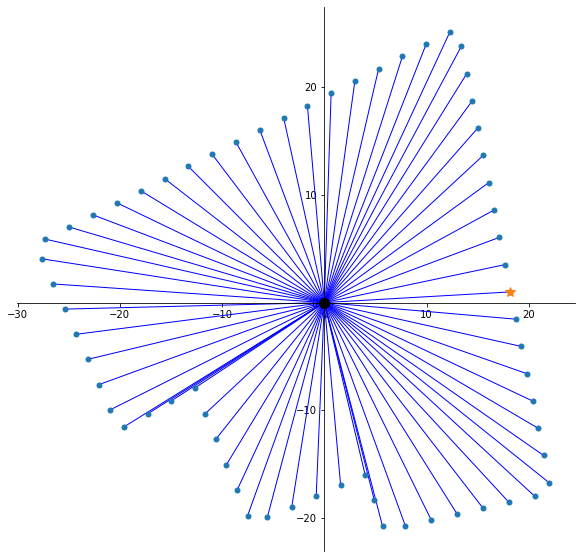

In [71]:
result_length,result_coords = splitPolygon(64,projected_gdf)
print(len(result_coords[0]))
print(len(result_length[0]))
print(len(result_length))

df = pd.DataFrame(result_coords[0],columns=['lon','lat'])
# gdf = GeoDataFrame(geofenceDf, geometry=result_coords)
print(df)

fig, ax = plt.subplots(figsize=(10,10))
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position(('data',0))  #data表示通过值来设置x轴的位置，将x轴绑定在y=0的位置
ax.spines['left'].set_position(('data',0))  #axes表示以百分比的形式设置轴的位置，即将y轴绑定在x轴50%的位置，也就是x轴的中点

for i in range(len(result_coords[0])):
    line = [(0,0),(df.lon[i],df.lat[i])]
    (line_xs, line_ys) = zip(*line)
    ax.add_line(Line2D(line_xs, line_ys, linewidth=1, color='blue'))

plt.plot(df.lon,df.lat,'.',markersize=10)
plt.plot(0,0,'.',markersize=20, color='black')
plt.plot(df.lon[0],df.lat[0],'*',markersize=10)

In [72]:
df2 = pd.DataFrame(result_length)
df2

,0
0,"[18.231646426458067, 18.017157776772187, 18.17..."
1,"[58.59022619656411, 59.89881492062485, 61.6848..."
